In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy.stats as s
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

Devnagri Handwritten characters is a dataset consisting of numbers and letters of the Devnagri Script.<br>
We have 46 classes, 1700 images per class to give us a total of 78200 images.<br>
Each image is 32x32 black and white image.

In [3]:
def Load_data(path_of_folders):
    classes=list()
    img_array=list()
    list_of_folders = os.listdir(path_of_folders)
    for folder in list_of_folders:
        path = os.path.join(path_of_folders,folder)
        list_of_images = os.listdir(path)
        for images in list_of_images:
            path2 = os.path.join(path,images)
            img = plt.imread(path2)
            classes.append(str(folder))
            img=img.reshape(1,1024)
            img_array.extend(img)
    img_array = np.array(img_array)
    classes = np.array(classes,dtype=str)
    classes_n = np.zeros(classes.shape,dtype=int)
    img_array = pd.DataFrame(img_array)
    l=list(np.unique(classes))
    for i in range(len(classes)):
        classes_n[i]=l.index(classes[i])
    return (img_array,classes,classes_n)

In [4]:
#load training data
path_of_train_folders = 'D:/Datasets/DevanagariHandwrittenCharacterDataset/Train'
raw_data,classes_train_alpha,classes_train_n = Load_data(path_of_train_folders)

In [5]:
#Load testing data
path_of_test_folders = 'D:/Datasets/DevanagariHandwrittenCharacterDataset/Test'
test_data,classes_test_alpha,classes_test_n = Load_data(path_of_test_folders)

In [6]:
raw_data_copy = raw_data.copy()
test_data_copy = test_data.copy()

In [7]:
#Create cross validation data
cross_val_data=test_data.iloc[0:170]
cross_val_classes=list(classes_test_n[0:170])
for i in range(1,46):
    cross_val_data=cross_val_data.append(test_data.iloc[i*300:i*300+170])
    cross_val_classes.extend(classes_test_n[i*300:i*300+170])

character_18_da


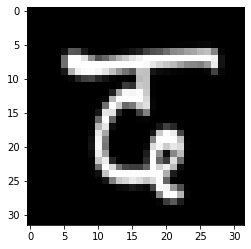

In [8]:
#Example of an image
a=np.array(raw_data.iloc[15000,0:1024],dtype=float)
plt.imshow(a.reshape(32,32),cmap='gray')
print(classes_train_alpha[15000])

Data normalisation is an important part of the pre-processing stage. We can use two types of normalisation:-<br>

### Z-Score Normalisation
<br>
$Z = \frac{x-\mu}{\sigma}$
<br>

### Min-Max Normalisation
<br>
$Z = \frac{x-Min}{Max-Min}$

In [9]:
#Z-score normalisation
#calculate mu for all the features
mu_vector = []
for i in range(1024):
    mu_vector.append(raw_data_copy.iloc[:,i].mean())
mu_vector = np.array(mu_vector)
std_vector = []
for i in range(1024):
    std_vector.append(raw_data_copy.iloc[:,i].std())
std_vector = np.array(std_vector)

std_vector = std_vector.reshape(1024,1)
mu_vector = mu_vector.reshape(1024,1)

for i in range(1024):
    raw_data_copy.iloc[:,i] = raw_data_copy.iloc[:,i]-mu_vector[i]
    if std_vector[i]!=0:
        raw_data_copy.iloc[:,i] = raw_data_copy.iloc[:,i]/std_vector[i]

In [10]:
# Normalize testing data
for i in range(1024):
    test_data_copy.iloc[:,i] = test_data_copy.iloc[:,i]-mu_vector[i]
    if std_vector[i]!=0:
        test_data_copy.iloc[:,i] = test_data_copy.iloc[:,i]/std_vector[i]

For simplicity we are considering our data to follow the Multivariate Normal Distribution<br>
The formula for Multivariate-Gaussian PDF is:-<br>

${\large \frac{e^{-0.5[x-\mu]^T \Sigma^{-1}_i [x-\mu]}}{\sqrt{2\pi}^k \sqrt{|\Sigma_i|}}}$

is applicable only when $\Sigma$ is non-singular

This condition put on $\Sigma$ being non singular is due to the fact that we have to calculate the inverse of the class covariance matrix ($\Sigma$)<br>
This is the biggest challenge<br>

Let us see why

In [12]:
#calculate covariance matrix and check determinants
cov_matrices = []
for i in range(46):
    cov_matrices.append(raw_data_copy.iloc[i*1700:(i+1)*1700].cov())
    print(np.linalg.det(cov_matrices[-1]),end='  ')

0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In the given data we have 32x32 = 1024 dimensions<br>
if you check the data you will see that most of the columns are Linearly Dependant or sparse. This makes our covariance matrix singular. To overcome this issue, we use a dimensionality reduction technique called PCA or Principal Component Analysis.<br>

PCA projects our data along a combination of dimensions which have maximum variance in them.<br>
For further reference read this wonderful article on $\href{https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c}{PCA}$

There are various ways to apply PCA. We will do so with the help of Singular Value Decomposition

In [14]:
cov_matrix = raw_data_copy.cov()
q,lamb,qt=np.linalg.svd(cov_matrix)
trace=sum(lamb)
indices=[]
f_vector=[]
sm=0
for i in range(len(lamb)):
    sm+=lamb[i]
    #we can specify the amount of variance we want to preserve
    if sm/trace<0.99:
        indices.append(np.argmax(q[i]))
        f_vector.append(q[:,i])
    else:
        break
f_vector = np.array(f_vector)
print(f_vector.shape)

(407, 1024)


In [15]:
new_data = (raw_data_copy@f_vector.T)
new_data = pd.DataFrame(new_data)
print(np.linalg.det(new_data.cov()))

8.858221139319408e-171


Even after PCA the determinant is close to 0 which might result in an error during the calculation of inverse of $\Sigma$ <br>

Now we will apply another dimensionality technique called RDA or Regularised Discriminant Analysis on our Covariance matrix<br>

RDA is somewhat of a mixture of the LDA and QDA<br>
Go back to our Multivariate-Gaussian PDF and check how we are calculating it. LDA assumes that <br>
$\Sigma_0 = \Sigma_1 = \Sigma_2 = \dots = \Sigma_k = \Sigma_{pooled}$  

Whereas QDA assumes that all class covariance matrices are unique<br>
RDA is a tradeoff between both the assumptions<br>
RDA = $\alpha$ LDA + $(1-\alpha)$ QDA <br>
$\alpha \, \epsilon \,  [0,1]$
<br>
Although we will use a modified version of RDA:- <br>
$\Sigma_i ^ r =\sum_{i=0}^{k} (1-\gamma)\Sigma_i + \gamma \sigma I_{MxM}$
<br>
$\sigma = trace( \Sigma_{pooled})$

In [16]:
#calculate covariance matrices for all the classes after PCA
cov_matrices_ap = []
for i in range(46):
    cov_matrices_ap.append(new_data.iloc[i*1700:(i+1)*1700].cov())

$\Sigma_{pooled} = \frac{\sum_{i=0}^{k} (N_i-1)\Sigma_i}{\sum_{i=0}^{k} N_i - k}$

In [17]:
#LDA
#calculate pooled covariance
pooled_cov=0
for i in cov_matrices_ap:
    pooled_cov = 1699*i + pooled_cov
pooled_cov = pooled_cov/(78200-46)

$\alpha \,\&\, \gamma$ are Hyperparameters<br>
$\therefore$ We need to tune them with the help of Cross-validation data<br>
We can perform either a grid search or a random search for the Hyperparameters as there doesn not exist any heuristic for choosing them

In [18]:
def Calc_ans(likelihood,data_size,classes):
    ans=[]
    for i in range(data_size):
        m=[]
        for j in range(46):
            m.append((likelihood[j][i],j))
        ans.append((i,min(m)))
    count=0
    for i in range(data_size):
        if int(ans[i][1][1])==classes[i]:
            count+=1
    return count

In [ ]:
cross_val_data = cross_val_data@f_vector.T
cross_val_data = pd.DataFrame(cross_val_data)

In [22]:
vals=[]
sigma=np.trace(pooled_cov)/pooled_cov.shape[0]
for i in tqdm(range(30)):
    lam=np.random.uniform()
    rda=[]
    for j in cov_matrices_ap:
        rda.append(j*lam + (1-lam)*pooled_cov)
    gamma=np.random.uniform()
    rda_dash=[]
    for k in range(46):
        rda_dash.append((1-gamma)*rda[k] + gamma*sigma*np.identity(rda[k].shape[0]))
    likelihood_cross_val=[]
    for l in range(46):
        #likelihood probabilities can get very small
        #Therefore we use -log to solve the problem of underflow
        likelihood_cross_val.append(-np.log(s.multivariate_normal.pdf(cross_val_data,cross_val_data.iloc[i*170:(i+1)*170].mean(),rda_dash[l])))
    count=Calc_ans(likelihood_cross_val,cross_val_data.shape[0],cross_val_classes)
    vals.append([count,lam,gamma])

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:15<00:00,  6.51s/it]


In [23]:
#check the values
ind=np.argmax(vals)
vals[ind//3]

[5573, 0.5924238472072683, 0.9067736504261744]

In [45]:
#use these values in training
lam=vals[ind//3][1]
rda=[]
for j in cov_matrices_ap:
    rda.append(j*lam + (1-lam)*pooled_cov)
gamma=vals[ind//3][2]
rda_dash=[]
sigma=np.sum(np.diag(pooled_cov))/pooled_cov.shape[0]
for k in range(46):
    rda_dash.append((1-gamma)*rda[k] + gamma*sigma*np.identity(rda[k].shape[0]))

In [46]:
#training likelihood
likelihood_train=[]
for i in range(46):
    a = -np.log(s.multivariate_normal.pdf(new_data,new_data.iloc[i*1700:(i+1)*1700].mean(),rda_dash[i]))
    likelihood_train.append(a)

In [47]:
#training accuracy
count_train = Calc_ans(likelihood_train,new_data.shape[0],classes_train_n)
print(count_train/new_data.shape[0])

0.836764705882353


In [ ]:
test_data_copy = test_data_copy@f_vector.T
test_data_copy = pd.DataFrame(test_data_copy)

In [48]:
#testing likelihood
likelihood_test=[]
for i in range(46):
    likelihood_test.append(-np.log(s.multivariate_normal.pdf(test_data_copy,new_data.iloc[i*1700:(i+1)*1700].mean(),rda_dash[i])))

In [49]:
#testing accuracy
count_test = Calc_ans(likelihood_test,test_data.shape[0],classes_test_n)
print(count_test/test_data.shape[0])

0.8261594202898551
